<a href="https://colab.research.google.com/github/byy-bayu/GEO-AI-Machine-Learning-for-Paddy-Phenology-Classification/blob/main/ML_Klasifikasi_fenologi_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Kode program untuk melakukan klasifikasi fenologi fase tanam padi di Kabupaten Indramayu dengan algoritma Geo AI (ML)**  

Dibuat oleh : [Bayu Ardiyanto]  
Tanggal : [21 Februari 2025]  
Diubah : [6 Maret 2025]  


**Poin-Poin Penting pada Proses Klasifikasi di Kode ini**  

- **Dataset citra Sentinel-1** &nbsp;&nbsp;Merupakan citra Sentinel-1 ARD (*Analysis Ready Data*) yang telah diolah menggunakan GEE. Citra berisi 2 band polarisasi (**VV** dan **VH**), 4 band indeks turunan (**RPI, API, NDPI, RVI**), dan band *angle*. Raster memiliki format data **Float32**. Processing citra di GEE untuk mendapatkan data ARD dapat diakses pada repository: 👉 [GEE Repository](https://code.earthengine.google.com/?accept_repo=users/bayuardianto104/Indramayu_Research_TA).  

- **Dataset sample** &nbsp;&nbsp;Merupakan titik (*point*) sample (data csv: pandas).  👉 [sample data](https://drive.google.com/file/d/1VirZvHdqMce4kKA3bD_w59hd7p3_Y7qI/view?usp=sharing)..  

- **Metode Klasifikasi** &nbsp;&nbsp;Menerapkan algoritma *machine learning* **SVM**.  
  Menerapkan *Hyperparameter tuning* dengan metode `GridSearchCV`, menggunakan parameter:   `C`   `kernel`   `gamma`   `degree`   `coef0`


## Menginput Dataset citra Sentinel-1
Pada part ini kita akan menginput dataset citra Sentinel-1 ke dalam pemrosesan, memastikan data yang digunakan sesuai dengan kebutuhan analisis

In [ ]:
!pip install rasterio

import ee
import geemap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.dates as mdates
import rasterio
import os

from datetime import datetime
from google.colab import drive

import glob

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 90.4 MB/s eta 0:00:00


In [ ]:
# Authenticate to Earth Engine.
ee.Authenticate()

# Initialize the library.
ee.Initialize(project='ee-bayuardianto104')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load citra dan simpan dalam dictionary
file_paths = [
    "/content/drive/MyDrive/Research Sentinel-1 Dataset_S1-ARD_Indramayu_2024/Sentinel1_2024-01_Dasarian-1_float.tif",
    "/content/drive/MyDrive/Research Sentinel-1 Dataset_S1-ARD_Indramayu_2024/Sentinel1_2024-01_Dasarian-2_float.tif",
    "/content/drive/MyDrive/Research Sentinel-1 Dataset_S1-ARD_Indramayu_2024/Sentinel1_2024-01_Dasarian-3_float.tif",
    "/content/drive/MyDrive/Research Sentinel-1 Dataset_S1-ARD_Indramayu_2024/Sentinel1_2024-02_Dasarian-1_float.tif",
    "/content/drive/MyDrive/Research Sentinel-1 Dataset_S1-ARD_Indramayu_2024/Sentinel1_2024-02_Dasarian-2_float.tif",
    "/content/drive/MyDrive/Research Sentinel-1 Dataset_S1-ARD_Indramayu_2024/Sentinel1_2024-02_Dasarian-3_float.tif",
]

# Dictionary untuk menyimpan data raster (NumPy array)
raster_data = {}

# Dictionary untuk menyimpan metadata raster
raster_metadata = {}

In [ ]:
# Loop untuk membaca file dan menyimpannya dalam dictionary
for path in file_paths:
    with rasterio.open(path) as dataset:  # Gunakan "with" agar file tertutup otomatis
        filename = path.split("/")[-1].replace(".tif", "")

        # Baca data raster sebagai NumPy array
        raster_array = dataset.read()

        # Ubah format dari (Bands, Height, Width) => (Height, Width, Bands)
        raster_array = raster_array.transpose(1, 2, 0)

        # Simpan data raster
        raster_data[filename] = raster_array

        # Simpan metadata dalam dictionary
        raster_metadata[filename] = {
            "crs": dataset.crs,
            "transform": dataset.transform,
            "descriptions": dataset.descriptions,
            "shape": raster_array.shape
        }

        # Print informasi
        print(f"{filename} shape (NumPy): {raster_array.shape}")

Sentinel1_2024-01_Dasarian-1_float shape (NumPy): (4495, 7462, 7)
Sentinel1_2024-01_Dasarian-2_float shape (NumPy): (4495, 7462, 7)
Sentinel1_2024-01_Dasarian-3_float shape (NumPy): (4495, 7462, 7)
Sentinel1_2024-02_Dasarian-1_float shape (NumPy): (4495, 7462, 7)
Sentinel1_2024-02_Dasarian-2_float shape (NumPy): (4495, 7462, 7)
Sentinel1_2024-02_Dasarian-3_float shape (NumPy): (4495, 7462, 7)


In [ ]:
# Loop untuk menampilkan deskripsi band
for filename, meta in raster_metadata.items():
    # Periksa apakah descriptions tersedia, jika None maka ganti dengan "Band X"
    band_descriptions = [desc if desc else f"Band {idx+1}" for idx, desc in enumerate(meta["descriptions"])]

    # Gabungkan deskripsi band menjadi satu string
    desc = ", ".join(band_descriptions)

    print(f"Raster description ({filename}): ({desc})")

Raster description (Sentinel1_2024-01_Dasarian-1_float): (RPI, VV_int, VH_int, API, NDPI, RVI, angle)
Raster description (Sentinel1_2024-01_Dasarian-2_float): (RPI, VV_int, VH_int, API, NDPI, RVI, angle)
Raster description (Sentinel1_2024-01_Dasarian-3_float): (RPI, VV_int, VH_int, API, NDPI, RVI, angle)
Raster description (Sentinel1_2024-02_Dasarian-1_float): (RPI, VV_int, VH_int, API, NDPI, RVI, angle)
Raster description (Sentinel1_2024-02_Dasarian-2_float): (RPI, VV_int, VH_int, API, NDPI, RVI, angle)
Raster description (Sentinel1_2024-02_Dasarian-3_float): (RPI, VV_int, VH_int, API, NDPI, RVI, angle)


In [ ]:
# Cek metadata
print("\nExample metadata:")
print(raster_metadata[file_paths[0].split('/')[-1].replace('.tif', '')])


Example metadata:
{'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'), 'transform': Affine(8.983152841195215e-05, 0.0, 107.85047536999198,
       0.0, -8.983152841195215e-05, -6.252633703585518), 'descriptions': ('RPI', 'VV_int', 'VH_int', 'API', 'NDPI', 'RVI', 'angle'), 'shape': (4495, 7462, 7)}


## Persiapan Input Data Untuk SVM training process
Pada part ini kita akan menginput dan memproses sample data (sebagai training dan testing data)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
# Load dataset dari Google Drive
file_path = "/content/drive/MyDrive/Research/data latih.csv"
df = pd.read_csv(file_path)

# Specify the columns you want to use as features
feature_columns = ['VV_int', 'VH_int', 'RPI', 'API', 'NDPI', 'RVI']
# feature_columns = ['RPI', 'API', 'NDPI', 'RVI']

# Extract features and labels
features = df[feature_columns]
labels = df['phenology'] # Target Column

# Split data: 80% untuk training, 20% untuk testing
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, stratify=labels, random_state=42
)

# Print ukuran dataset setelah split
print("Training set:", X_train.shape, y_train.shape)
print("Testing set:", X_test.shape, y_test.shape)

# # Print beberapa baris pertama dari training set
# print("\nHead of X_train:")
# print(X_train.head())

# print("\nHead of y_train:")
# print(y_train.head())

Training set: (870, 6) (870,)
Testing set: (218, 6) (218,)


## SVM Training Process and Evaluation Assessment
Pada part ini kita akan melakukan training RF menggunakan gridsearch cv untuk mencari parameter terbaik.

### Hyperparameter tuning menggunakan GridSearchCV

In [ ]:
# Import library
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

import time

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.inspection import permutation_importance
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import joblib

In [ ]:
# SVM Classifier awal
init_svm_model = SVC(random_state=42)

In [ ]:
#mendefinisikan list beberapa paremeter yang akan digunakan untuk hyperparameter tuning
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto', 0.01, 0.1, 1],
    'degree': [2, 3, 4],  # degree untuk kernel 'poly'
    'coef0': [0.0, 0.1, 0.5]  # Parameter independen untuk kernel 'poly' dan 'sigmoid'
}

In [ ]:
# GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(
    estimator=init_svm_model,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=5
)

In [ ]:
# Start the timer
start_time = time.time()

# Train RF model dengan grid_search
grid_search.fit(X_train, y_train)

# End the timer
end_time = time.time()

# Calculate and print the time taken
elapsed_time = end_time - start_time
print(f"Waktu yang dibutuhkan untuk running adalah: {elapsed_time:.3f} seconds")

Fitting 5 folds for each of 540 candidates, totalling 2700 fits
Waktu yang dibutuhkan untuk running adalah: 125.788 seconds


In [ ]:
# Print the best parameters
print("Best parameters adalah:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

Best parameters adalah: {'C': 100, 'coef0': 0.1, 'degree': 4, 'gamma': 'scale', 'kernel': 'poly'}
Best cross-validation accuracy: 0.4390804597701149


In [ ]:
# Menggunakan scikit-learn library untuk menghitung overall accuacy, classification report, dan confusion metrix
#Menerapkan best parameter RF

best_svm = grid_search.best_estimator_

# Menerapkan RF_model_default untuk memprediksi kelas dari tetsing dataset
y_pred_grid = best_svm.predict(X_test)

<ipython-input-23-9aaf46b9c1fe>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances, y=band_descriptions, palette='viridis')


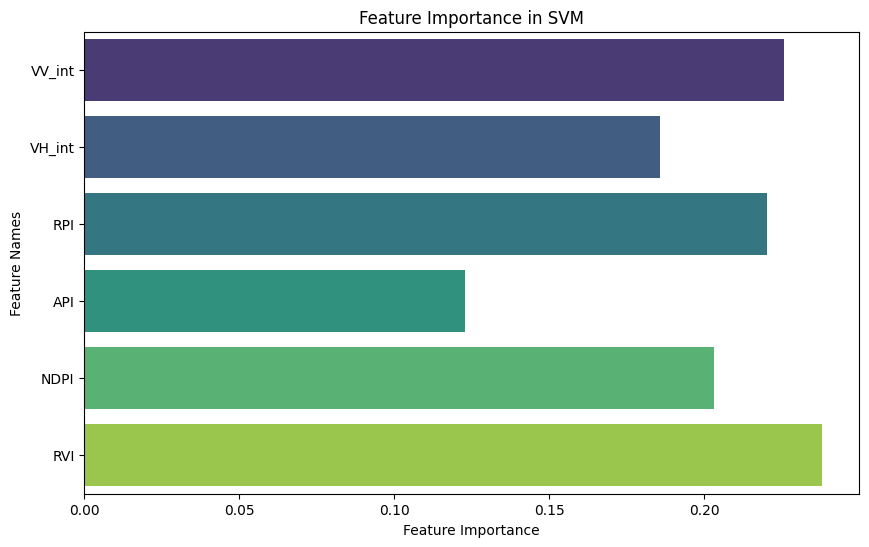

In [ ]:
# feature importance Menggunakan permutation Importance
# Hitung permutation importance
result = permutation_importance(best_svm, X_test, y_test, n_repeats=10, random_state=42)

# Ambil nilai importance
feature_importances = result.importances_mean

# Band list
band_descriptions = ['VV_int', 'VH_int', 'RPI', 'API', 'NDPI', 'RVI']
# band_descriptions = ['RPI', 'API', 'NDPI', 'RVI']
# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=band_descriptions, palette='viridis')
plt.xlabel("Feature Importance")
plt.ylabel("Feature Names")
plt.title("Feature Importance in SVM")
plt.show()

In [ ]:
# uji akurasi model
def evaluate_classification(y_true, y_pred):
    # Perhitungan overall accuracy
    OA = accuracy_score(y_true, y_pred)
    print(f"Overall Accuracy: {OA:.4f}")

    # Menghitung classification report dan mengubahnya ke dalam bentuk dictionary
    class_names = ['flooding', 'early_veg', 'veg_1', 'veg_2', 'gen_1', 'gen_2', 'bare']
    report = classification_report(y_true, y_pred, target_names=class_names, digits=4, output_dict=True)

    # Membuat data untuk heatmap classification report
    metrics = ['precision', 'recall', 'f1-score']
    labels = class_names + ['accuracy', 'macro avg', 'weighted avg']
    report_data = []

    # Data untuk kelas individual
    for label in class_names:
        row = []
        for metric in metrics:
            row.append(report[label][metric])
        report_data.append(row)

    # Data untuk accuracy
    accuracy_row = [np.nan, np.nan, report['accuracy']]
    report_data.append(accuracy_row)

    # Data untuk macro avg dan weighted avg
    for avg_type in ['macro avg', 'weighted avg']:
        row = []
        for metric in metrics:
            row.append(report[avg_type][metric])
        report_data.append(row)

    # Membuat subplot dengan 2 gambar (vertikal)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))  # 2 rows, 1 column

    # Plot heatmap untuk classification report
    sns.heatmap(report_data, annot=True, fmt='.4f', cmap='coolwarm',
                xticklabels=metrics, yticklabels=labels, ax=ax1)
    ax1.set_title('Uji Akurasi Model Klasifikasi Fenologi Algoritma Support Vector Machine', fontsize=14)
    ax1.set_xlabel('Metrics')
    ax1.set_ylabel('Classes')

    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=class_names, yticklabels=class_names, ax=ax2)
    ax2.set_xlabel('Predicted Label')
    ax2.set_ylabel('True Label')
    ax2.set_title('Confusion Matrix Model Klasifikasi Fenologi Algoritma Support Vector Machine', fontsize=14)

    plt.tight_layout()
    plt.show()

Overall Accuracy: 0.4725


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


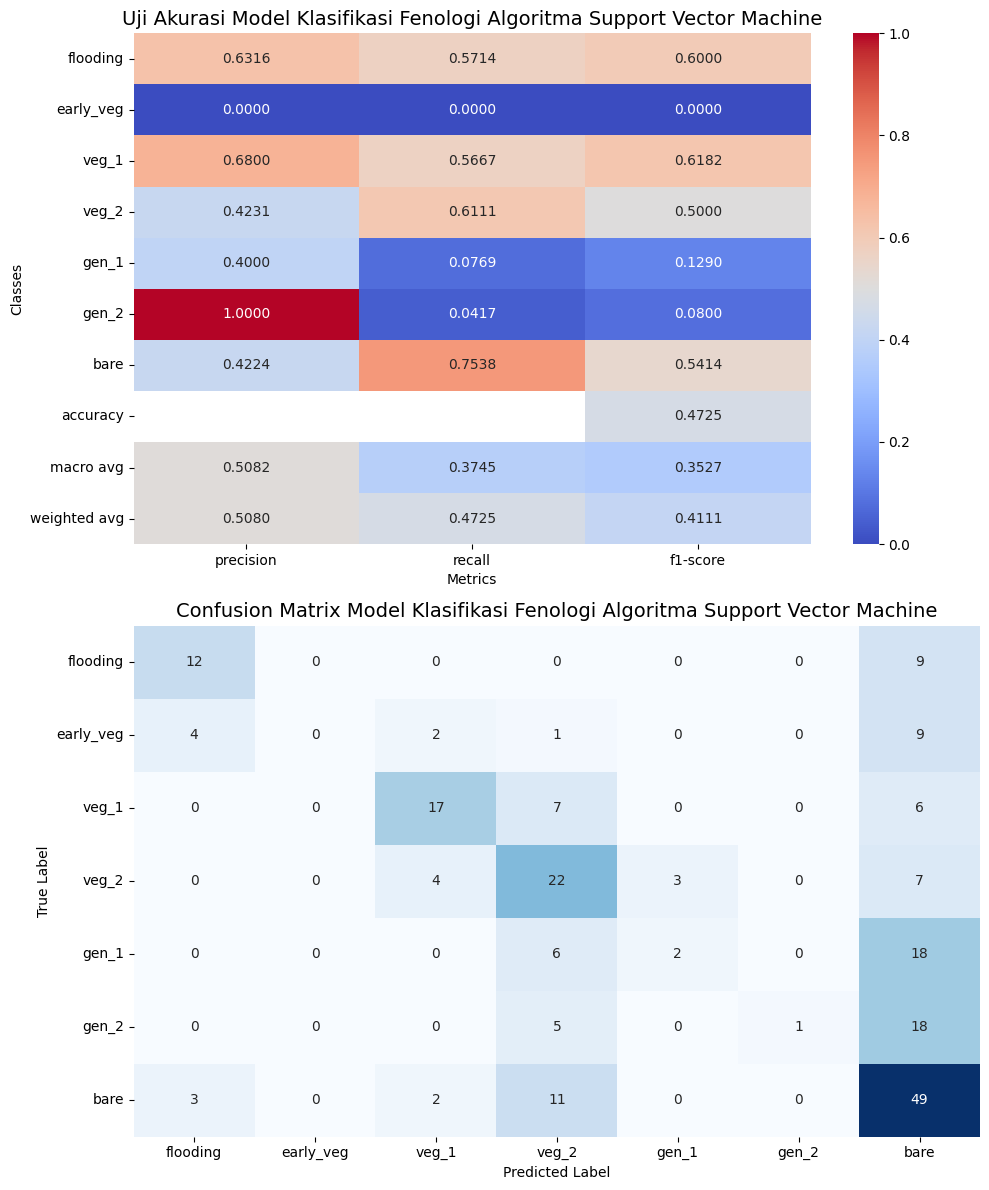

In [ ]:
# Menerapkan function evaluation assessment dengan data yang sebenarnya atau y_test dan data hasil prediksi
evaluate_classification(y_test, y_pred_grid)

In [ ]:
# import joblib
# Save the model
joblib.dump(best_svm, '/content/drive/MyDrive/Research.pkl')

['/content/drive/MyDrive/Research.pkl']

### Menghasilkan peta Klasifikasi fenologi fase tanam padi


In [ ]:
# import AOi kita menggunakan geopandas
import geopandas as gpd

import rasterio
from rasterio.mask import mask
import numpy as np
import matplotlib.pyplot as plt
import joblib

import pandas as pd

In [ ]:
#import AOI
AOI = gpd.read_file('/content/drive/MyDrive/Research/shp/sawah_DSU_dss._project1.shp')

In [ ]:
# Train n apply classification in each dasarian
# Apply model untuk mendapatkan peta klasifikasi
def classify_raster(raster_data, model, feature_names):
    # Pilih 6 band pertama
    raster_data = raster_data[:, :, :6]  # 6 band pertama: (RPI, VV_int, VH_int, API, NDPI, RVI)
    # raster_data = raster_data[:, :, :4]  # 6 band pertama: (RPI, VV_int, VH_int, API, NDPI, RVI)
    # Reshape data raster ke bentuk (jumlah_piksel, jumlah_band)
    height, width, num_bands = raster_data.shape
    raster_reshaped = raster_data.reshape(-1, num_bands)  # Bentuk (height * width, band)

    # Konversi ke pandas.DataFrame dengan nama fitur
    raster_df = pd.DataFrame(raster_reshaped, columns=feature_names)

    # Cek piksel yang memiliki nilai NaN
    mask = np.isnan(raster_reshaped).any(axis=1)  # Mask untuk piksel NaN

    # Buat array untuk menyimpan hasil prediksi
    classification_result = np.full(raster_reshaped.shape[0], np.nan)  # Isi awal dengan NaN

    # Prediksi hanya untuk piksel yang tidak memiliki NaN
    if np.any(~mask):  # Jika ada piksel yang valid
        classification_result[~mask] = model.predict(raster_df[~mask])

    # Reshape kembali ke bentuk asli (height, width)
    return classification_result.reshape(height, width)

In [ ]:
# Nama fitur yang digunakan saat melatih model
feature_names = ['VV_int', 'VH_int', 'RPI', 'API', 'NDPI', 'RVI']
# feature_names = ['RPI', 'API', 'NDPI', 'RVI']
# Simpan hasil klasifikasi dalam dictionary
classified_data = {}

# Loop melalui setiap raster yang telah diproses
for key, raster in raster_data.items():
    if isinstance(raster, np.ndarray):
        # Panggil fungsi classify_raster dengan 3 argumen
        classified_data[key] = classify_raster(raster, best_svm, feature_names)
        print(f"{key} classified successfully")
    else:
        print(f"{key} is not a NumPy array. Skipping...")

Sentinel1_2024-01_Dasarian-1_float classified successfully
Sentinel1_2024-01_Dasarian-2_float classified successfully
Sentinel1_2024-01_Dasarian-3_float classified successfully
Sentinel1_2024-02_Dasarian-1_float classified successfully
Sentinel1_2024-02_Dasarian-2_float classified successfully
Sentinel1_2024-02_Dasarian-3_float classified successfully


### Visualisasi Peta fenologi fase tanam padi

In [ ]:
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap

import matplotlib.pyplot as plt

In [ ]:
# Mendefinisikan Legend dan warna untuk setiap kelas
legend_labels = ['flooding', 'early_veg', 'veg_1', 'veg_2', 'gen_1', 'gen_2', 'bare']
legend_colors = ['blue','limegreen', 'green', 'darkgreen', 'yellow', 'saddlebrown', 'red']

# Membuat figure untuk subplot berdasarkan jumlah classified_data
num_plots = len(classified_data)
fig, ax = plt.subplots(1, num_plots, figsize=(4*num_plots, 8))

# Pastikan ax selalu dalam bentuk array, bahkan jika hanya ada satu plot
if num_plots == 1:
    ax = [ax]

# Mendefinisikan colormap
cmap = ListedColormap(legend_colors)

# Membuat dictionary untuk nama bulan
month_names = {
    'S1_01': 'Januari',
    'S1_02': 'Februari',
    'S1_03': 'Maret',
    'S1_04': 'April',
    'S1_05': 'Mei',
    'S1_06': 'Juni',
    'S1_07': 'Juli',
    'S1_08': 'Agustus',
    'S1_09': 'September',
    'S1_10': 'Oktober',
    'S1_11': 'November',
    'S1_12': 'Desember'
}

# Judul untuk seluruh figure
fig.suptitle('Klasifikasi Fenologi Fase Tanam - Dasarian 1', fontsize=16)

# Looping untuk menampilkan setiap hasil klasifikasi
for i, (key, classified) in enumerate(sorted(classified_data.items())):
    # Mendapatkan nama bulan dari key
    month = month_names.get(key, key)

    # Display hasil klasifikasi
    im = ax[i].imshow(classified, cmap=cmap, extent=[AOI.total_bounds[0], AOI.total_bounds[2],
                                                    AOI.total_bounds[1], AOI.total_bounds[3]])
    ax[i].set_title(f'Bulan {month}')

    # Menambahkan legend hanya pada subplot pertama untuk menghemat ruang
    if i == 0:
        legend_handles = [mpatches.Patch(color=legend_colors[j], label=legend_labels[j])
                        for j in range(len(legend_labels))]
        ax[i].legend(handles=legend_handles, loc='upper left', title="Fase Tanam",
                    fontsize='x-small', title_fontsize='medium',
                    edgecolor="black", fancybox=True)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Menyesuaikan layout dengan judul utama
# plt.savefig('/content/drive/MyDrive/Geosoftware_Kekeringan_NDDI/Peta_Klasifikasi_Dasarian1.jpeg', dpi=600)
plt.show()

In [ ]:
# Mendefinisikan Legend dan warna untuk setiap kelas
legend_labels = ['flooding', 'early_veg', 'veg_1', 'veg_2', 'gen_1', 'gen_2', 'bare']
legend_colors = ['blue', 'limegreen', 'green', 'darkgreen', 'yellow', 'saddlebrown', 'red']

# Membuat figure untuk subplot berdasarkan jumlah classified_data
num_plots = len(classified_data)
fig, ax = plt.subplots(num_plots, 1, figsize=(6, 4*num_plots))

# Pastikan ax selalu dalam bentuk array, bahkan jika hanya ada satu plot
if num_plots == 1:
    ax = [ax]

# Mendefinisikan colormap
cmap = ListedColormap(legend_colors)

# Membuat dictionary untuk nama bulan
month_names = {
    'S1_01': 'Januari', 'S1_02': 'Februari', 'S1_03': 'Maret', 'S1_04': 'April',
    'S1_05': 'Mei', 'S1_06': 'Juni', 'S1_07': 'Juli', 'S1_08': 'Agustus',
    'S1_09': 'September', 'S1_10': 'Oktober', 'S1_11': 'November', 'S1_12': 'Desember'
}

# Judul untuk seluruh figure
fig.suptitle('Klasifikasi Fenologi Fase Tanam - Dasarian 1', fontsize=16)

# Looping untuk menampilkan setiap hasil klasifikasi
for i, (key, classified) in enumerate(sorted(classified_data.items())):
    # Mendapatkan nama bulan dari key
    month = month_names.get(key, key)

    # Tampilkan hasil klasifikasi di subplot vertikal
    im = ax[i].imshow(classified, cmap=cmap, extent=[AOI.total_bounds[0], AOI.total_bounds[2],
                                                     AOI.total_bounds[1], AOI.total_bounds[3]])
    ax[i].set_title(f'Periode: {month}')

    # Tambahkan legend untuk setiap subplot
    legend_handles = [mpatches.Patch(color=legend_colors[j], label=legend_labels[j])
                      for j in range(len(legend_labels))]
    ax[i].legend(handles=legend_handles, loc='upper left', title="Fase Tanam",
                 fontsize='small', title_fontsize='medium', edgecolor="black", fancybox=True)

# Sesuaikan tata letak
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### Export raster hasil klasifikasi

In [ ]:
import rasterio
from rasterio.transform import from_origin

import os
import numpy as np

from rasterio.crs import CRS
from rasterio.transform import Affine

In [ ]:
# Fungsi untuk membuat metadata berdasarkan metadata asli (tanpa descriptions)
def create_metadata_from_original(classified_map, original_metadata):
    meta = {
        'driver': 'GTiff',
        'height': classified_map.shape[0],
        'width': classified_map.shape[1],
        'count': 1,
        'dtype': 'int32',
        'crs': original_metadata['crs'],
        'transform': original_metadata['transform'],
        'compress': 'lzw',
        'nodata': 0  # Nilai NoData
    }
    return meta

# Direktori path Google Drive
google_drive_path = '/content/drive/MyDrive/Research Sentinel-1 Dataset_S1-ARD_Indramayu_2024'
os.makedirs(google_drive_path, exist_ok=True)

# Definisikan metadata asli
original_metadata = {
    'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'),
    'transform': Affine(8.983152841195215e-05, 0.0, 107.85047536999198, 0.0, -8.983152841195215e-05, -6.252633703585518),
    'shape': (4495, 7462, 7)
}

# Definisikan kategori klasifikasi dalam urutan yang benar (tetap diperlukan untuk legenda)
categories = ['flooding', 'early_veg', 'veg_1', 'veg_2', 'gen_1', 'gen_2', 'bare']

# Buat warna untuk setiap kelas (untuk visualisasi)
colors = {
    1: (0, 0, 255),      # flooding: biru
    2: (144, 238, 144),  # early_veg: hijau muda
    3: (0, 128, 0),      # veg_1: hijau
    4: (0, 80, 0),       # veg_2: hijau lebih tua
    5: (255, 255, 0),    # gen_1: kuning
    6: (139, 69, 19),    # gen_2: coklat tua
    7: (255, 0, 0)       # bare: merah
}

# Loop melalui setiap data klasifikasi dan ekspor ke Google Drive
for key, classified_map in classified_data.items():
    if isinstance(classified_map, np.ndarray):
        # Membuat nama file
        output_file = os.path.join(google_drive_path, f"classified_{key}.tif")

        # Buat salinan array untuk dimodifikasi
        clean_map = np.copy(classified_map)

        # Ganti nilai NaN dengan 0
        if np.isnan(clean_map).any():
            nan_count = np.sum(np.isnan(clean_map))
            print(f"Mengganti {nan_count} nilai NaN dalam {key}")
            clean_map = np.nan_to_num(clean_map, nan=0)

        # Buat metadata dari metadata asli (tanpa memasukkan descriptions)
        meta = create_metadata_from_original(clean_map, original_metadata)

        # Ekspor peta klasifikasi
        with rasterio.open(output_file, 'w', **meta) as dst:
            dst.write(clean_map.astype('int32'), 1)

            # Tambahkan color map
            color_map = {}
            for k, v in colors.items():
                color_map[k] = (v[0], v[1], v[2], 255)  # RGBA

            dst.write_colormap(1, color_map)

        print(f"Berhasil mengekspor klasifikasi untuk {key} ke {output_file}")

Mengganti 19201504 nilai NaN dalam Sentinel1_2024-01_Dasarian-1_float
Berhasil mengekspor klasifikasi untuk Sentinel1_2024-01_Dasarian-1_float ke /content/drive/MyDrive/Research Sentinel-1 Dataset_S1-ARD_Indramayu_2024/classified_Sentinel1_2024-01_Dasarian-1_float.tif
Mengganti 19201504 nilai NaN dalam Sentinel1_2024-01_Dasarian-2_float
Berhasil mengekspor klasifikasi untuk Sentinel1_2024-01_Dasarian-2_float ke /content/drive/MyDrive/Research Sentinel-1 Dataset_S1-ARD_Indramayu_2024/classified_Sentinel1_2024-01_Dasarian-2_float.tif
Mengganti 19201504 nilai NaN dalam Sentinel1_2024-01_Dasarian-3_float
Berhasil mengekspor klasifikasi untuk Sentinel1_2024-01_Dasarian-3_float ke /content/drive/MyDrive/Research Sentinel-1 Dataset_S1-ARD_Indramayu_2024/classified_Sentinel1_2024-01_Dasarian-3_float.tif
Mengganti 19201504 nilai NaN dalam Sentinel1_2024-02_Dasarian-1_float
Berhasil mengekspor klasifikasi untuk Sentinel1_2024-02_Dasarian-1_float ke /content/drive/MyDrive/Research Sentinel-1 Data

In [ ]:
# Fungsi untuk membuat metadata berdasarkan metadata asli (tanpa descriptions)
def create_metadata_from_original(classified_map, original_metadata):
    meta = {
        'driver': 'GTiff',
        'height': classified_map.shape[0],
        'width': classified_map.shape[1],
        'count': 1,
        'dtype': 'int32',
        'crs': original_metadata['crs'],
        'transform': original_metadata['transform'],
        'compress': 'lzw',
        'nodata': 0  # Nilai NoData
    }
    return meta

# Direktori path Google Drive
google_drive_path = '/content/drive/MyDrive/Research Sentinel-1 Dataset_S1-ARD_Indramayu_2024'
os.makedirs(google_drive_path, exist_ok=True)

# Definisikan metadata asli
original_metadata = {
    'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'),
    'transform': Affine(8.983152841195215e-05, 0.0, 107.85047536999198, 0.0, -8.983152841195215e-05, -6.252633703585518),
    'shape': (4495, 7462, 7)
}

# Definisikan kategori klasifikasi dalam urutan yang benar (tetap diperlukan untuk legenda)
categories = ['flooding', 'early_veg', 'veg_1', 'veg_2', 'gen_1', 'gen_2', 'bare']

# Buat warna untuk setiap kelas (untuk visualisasi)
colors = {
    1: (0, 0, 255),      # flooding: biru
    2: (144, 238, 144),  # early_veg: hijau muda
    3: (0, 128, 0),      # veg_1: hijau
    4: (0, 80, 0),       # veg_2: hijau lebih tua
    5: (255, 255, 0),    # gen_1: kuning
    6: (139, 69, 19),    # gen_2: coklat tua
    7: (255, 0, 0)       # bare: merah
}

# Loop melalui setiap data klasifikasi dan ekspor ke Google Drive
for key, classified_map in classified_data.items():
    if isinstance(classified_map, np.ndarray):
        # Membuat nama file
        output_file = os.path.join(google_drive_path, f"classified_{key}.tif")

        # # Buat salinan array untuk dimodifikasi
        # clean_map = np.copy(classified_map)

        # # Ganti nilai NaN dengan 0
        # if np.isnan(clean_map).any():
        #     nan_count = np.sum(np.isnan(clean_map))
        #     print(f"Mengganti {nan_count} nilai NaN dalam {key}")
        #     clean_map = np.nan_to_num(clean_map, nan=0)

        # Buat metadata dari metadata asli (tanpa memasukkan descriptions)
        # meta = create_metadata_from_original(clean_map, original_metadata)
        meta = create_metadata_from_original(classified_map, original_metadata)
        # Ekspor peta klasifikasi
        # with rasterio.open(output_file, 'w', **meta) as dst:
        #     dst.write(clean_map.astype('int32'), 1)
        with rasterio.open(output_file, 'w', **meta) as dst:
            dst.write(classified_map.astype('int32'), 1)

            # Tambahkan color map
            color_map = {}
            for k, v in colors.items():
                color_map[k] = (v[0], v[1], v[2], 255)  # RGBA

            dst.write_colormap(1, color_map)

        print(f"Berhasil mengekspor klasifikasi untuk {key} ke {output_file}")

<ipython-input-31-1f9824174a64>:63: RuntimeWarning: invalid value encountered in cast
  dst.write(classified_map.astype('int32'), 1)


Berhasil mengekspor klasifikasi untuk Sentinel1_2024-01_Dasarian-1_float ke /content/drive/MyDrive/Research Sentinel-1 Dataset_S1-ARD_Indramayu_2024/classified_Sentinel1_2024-01_Dasarian-1_float.tif
Berhasil mengekspor klasifikasi untuk Sentinel1_2024-01_Dasarian-2_float ke /content/drive/MyDrive/Research Sentinel-1 Dataset_S1-ARD_Indramayu_2024/classified_Sentinel1_2024-01_Dasarian-2_float.tif
Berhasil mengekspor klasifikasi untuk Sentinel1_2024-01_Dasarian-3_float ke /content/drive/MyDrive/Research Sentinel-1 Dataset_S1-ARD_Indramayu_2024/classified_Sentinel1_2024-01_Dasarian-3_float.tif
Berhasil mengekspor klasifikasi untuk Sentinel1_2024-02_Dasarian-1_float ke /content/drive/MyDrive/Research Sentinel-1 Dataset_S1-ARD_Indramayu_2024/classified_Sentinel1_2024-02_Dasarian-1_float.tif
Berhasil mengekspor klasifikasi untuk Sentinel1_2024-02_Dasarian-2_float ke /content/drive/MyDrive/Research Sentinel-1 Dataset_S1-ARD_Indramayu_2024/classified_Sentinel1_2024-02_Dasarian-2_float.tif
Berha

In [ ]:
# Direktori path Google Drive (memastikan variabel ini tersedia di cell berikutnya)
# Jika dijalankan terpisah, uncomment baris berikut:
# google_drive_path = '/content/drive/MyDrive/Research Sentinel-1 Dataset_S1-ARD_Indramayu_2024'
# categories = ['flooding', 'early_veg', 'veg_1', 'veg_2', 'gen_1', 'gen_2', 'bare']

# Buat file legenda umum untuk semua data
legend_file = os.path.join(google_drive_path, "klasifikasi_legenda_SVM.txt")
with open(legend_file, 'w') as f:
    f.write("LEGENDA KLASIFIKASI:\n")
    f.write("==================\n\n")
    for i, category in enumerate(categories, 1):
        f.write(f"Nilai {i}: {category}\n")
    f.write("\n0: NoData (tidak ada data)")

print(f"File legenda umum dibuat di: {legend_file}")

File legenda umum dibuat di: /content/drive/MyDrive/Research Sentinel-1 Dataset_S1-ARD_Indramayu_2024/klasifikasi_legenda_SVM.txt


### Analisis luasan

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

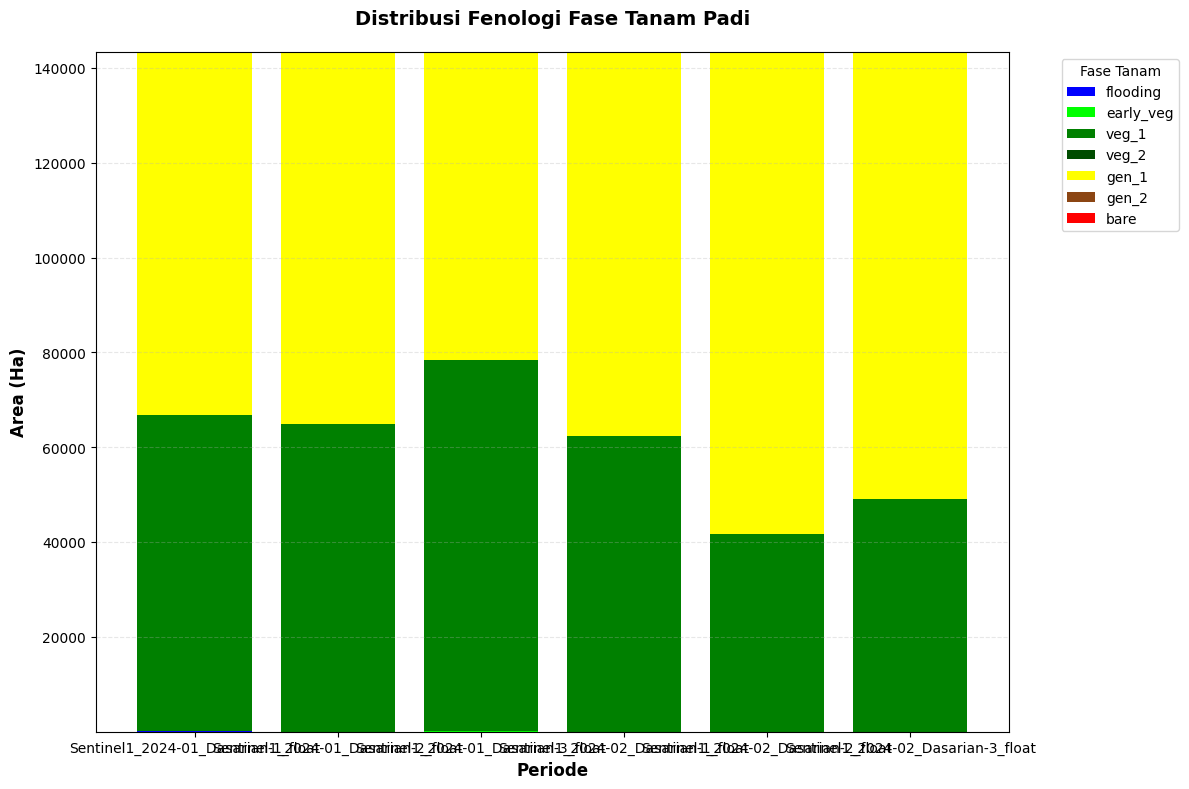

In [ ]:
# Tentukan label, kelas, dan ukuran piksel dalam hektar
labels = ['flooding', 'early_veg', 'veg_1', 'veg_2', 'gen_1', 'gen_2', 'bare']
classes = [0, 1, 2, 3, 4, 5, 6]
pixel_area_ha = 0.01  # 10x10 m sentinel-2

# Fungsi untuk menghitung luas kelas
def calculate_class_areas(classified_map, classes, pixel_area_ha):
    areas = {}
    total_area = 0
    for cls in classes:
        pixel_count = np.sum(classified_map == cls)
        area = pixel_count * pixel_area_ha
        areas[cls] = area
        total_area += area
    return areas, total_area

# Buat list untuk menyimpan hasil perhitungan area
area_results = []

# Loop melalui setiap periode dalam classified_data
for key, classified in classified_data.items():
    # Hitung area untuk periode tersebut
    areas, total_area = calculate_class_areas(classified, classes, pixel_area_ha)

    # Tambahkan hasil ke dalam list
    area_results.append({
        "periode": key,
        "flooding": areas[0],
        "early_veg": areas[1],
        "veg_1": areas[2],
        "veg_2": areas[3],
        "gen_1": areas[4],
        "gen_2": areas[5],
        "bare": areas[6]
    })

# Buat DataFrame dari list area_results
area_df = pd.DataFrame(area_results)

# Definisikan warna untuk setiap kelas
colors = [
    '#0000FF',  # Biru
    '#00FF00',  # Hijau Muda
    '#008000',  # Hijau
    '#004d00',  # Hijau Gelap
    '#FFFF00',  # Kuning
    '#8B4513',  # Coklat
    '#FF0000'  # Merah
]

# Buat stacked bar chart
plt.figure(figsize=(12, 8))

# Plot batang bertumpuk
bottom = np.zeros(len(area_df["periode"]))
for i, col in enumerate(labels):
    plt.bar(area_df["periode"], area_df[col], bottom=bottom,
            label=col, color=colors[i])
    bottom += area_df[col]

# Kustomisasi plot
plt.xlabel('Periode', fontsize=12, fontweight='bold')
plt.ylabel('Area (Ha)', fontsize=12, fontweight='bold')
plt.title('Distribusi Fenologi Fase Tanam Padi',
          fontsize=14, fontweight='bold', pad=20)

# Atur legend
plt.legend(title='Fase Tanam',
          bbox_to_anchor=(1.05, 1),
          loc='upper left')

# Tambahkan grid
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Atur layout agar legend tidak terpotong
plt.tight_layout()

# Tampilkan plot
plt.show()

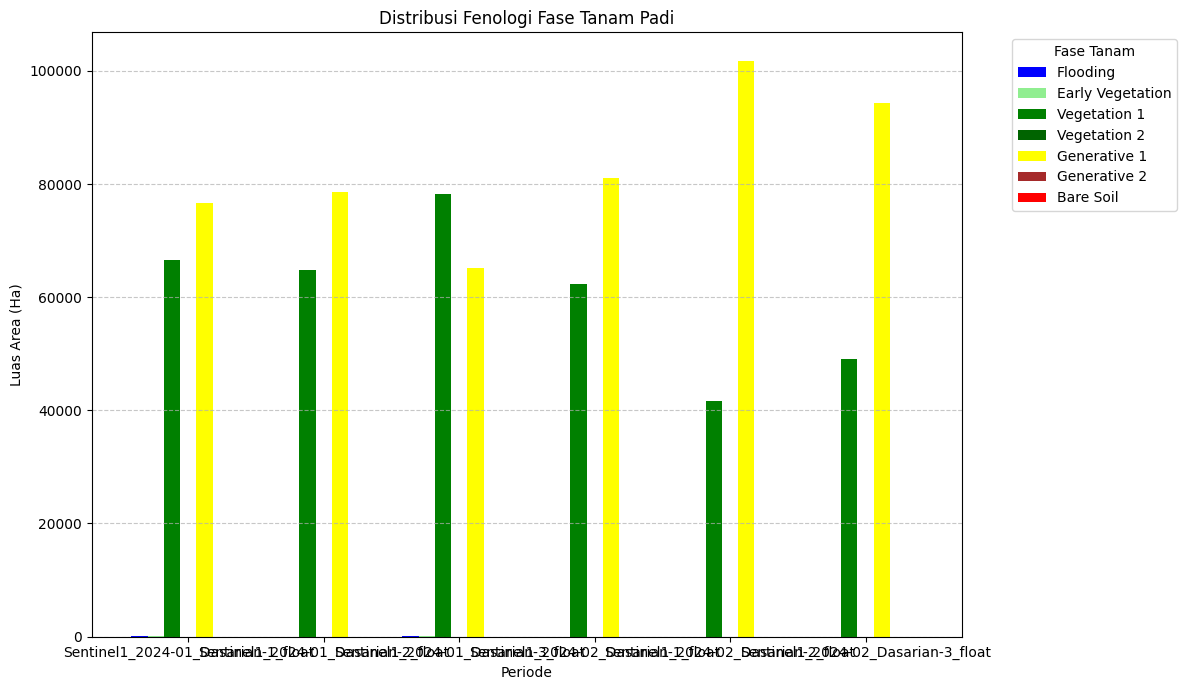

In [ ]:
# Tentukan label, kelas, dan ukuran piksel dalam hektar
labels = ['Flooding', 'Early Vegetation', 'Vegetation 1', 'Vegetation 2', 'Generative 1', 'Generative 2', 'Bare Soil']
classes = [0, 1, 2, 3, 4, 5, 6]
pixel_area_ha = 0.01  # 10x10 m Sentinel-2

# Fungsi untuk menghitung luas kelas
def calculate_class_areas(classified_map, classes, pixel_area_ha):
    areas = {cls: np.sum(classified_map == cls) * pixel_area_ha for cls in classes}
    return areas

# Buat dictionary untuk menyimpan hasil perhitungan area
area_results = {}

# Loop melalui setiap periode dalam classified_data
for key, classified in classified_data.items():
    # Hitung area untuk periode tersebut
    areas = calculate_class_areas(classified, classes, pixel_area_ha)
    area_results[key] = areas

# Buat DataFrame untuk analisis
area_df = pd.DataFrame({
    "Class": labels,
    **{key: [area_results[key][cls] for cls in classes] for key in area_results}
})

# Print DataFrame
# print(area_df)

# Warna untuk setiap kelas fenologi
colors = ['blue', 'lightgreen', 'green', 'darkgreen', 'yellow', 'brown', 'red']

# Plot the data
plt.figure(figsize=(12, 7))

# Indeks untuk sumbu X
x = np.arange(len(area_df.columns[1:]))  # Indeks untuk periode
bar_width = 0.12  # Lebar batang

# Plot bars untuk setiap kelas fenologi
for i, cls in enumerate(classes):
    plt.bar(x + i * bar_width, area_df.iloc[i, 1:], width=bar_width, label=labels[i], color=colors[i])

# Add labels, title, and grid
plt.xticks(x + (len(classes) - 1) * bar_width / 2, area_df.columns[1:])  # Posisi label periode di tengah grup batang
plt.xlabel('Periode')
plt.ylabel('Luas Area (Ha)')
plt.title('Distribusi Fenologi Fase Tanam Padi')
plt.legend(title='Fase Tanam', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Direktori penyimpanan: /content/drive/MyDrive/Research Sentinel-1 Dataset_S1-ARD_Indramayu_2024
Direktori ada dan siap digunakan: True
Distribusi Luas Area per Fase Tanam (Ha):
         Fase Tanam  Sentinel1_2024-01_Dasarian-1_float  \
0          Flooding                               27.63   
1  Early Vegetation                               31.95   
2      Vegetation 1                            66662.28   
3      Vegetation 2                                0.09   
4      Generative 1                            76679.91   
5      Generative 2                                0.00   
6         Bare Soil                                0.00   

   Sentinel1_2024-01_Dasarian-2_float  Sentinel1_2024-01_Dasarian-3_float  \
0                                0.90                               16.29   
1                                1.53                              

NameError: name 'info_path' is not defined

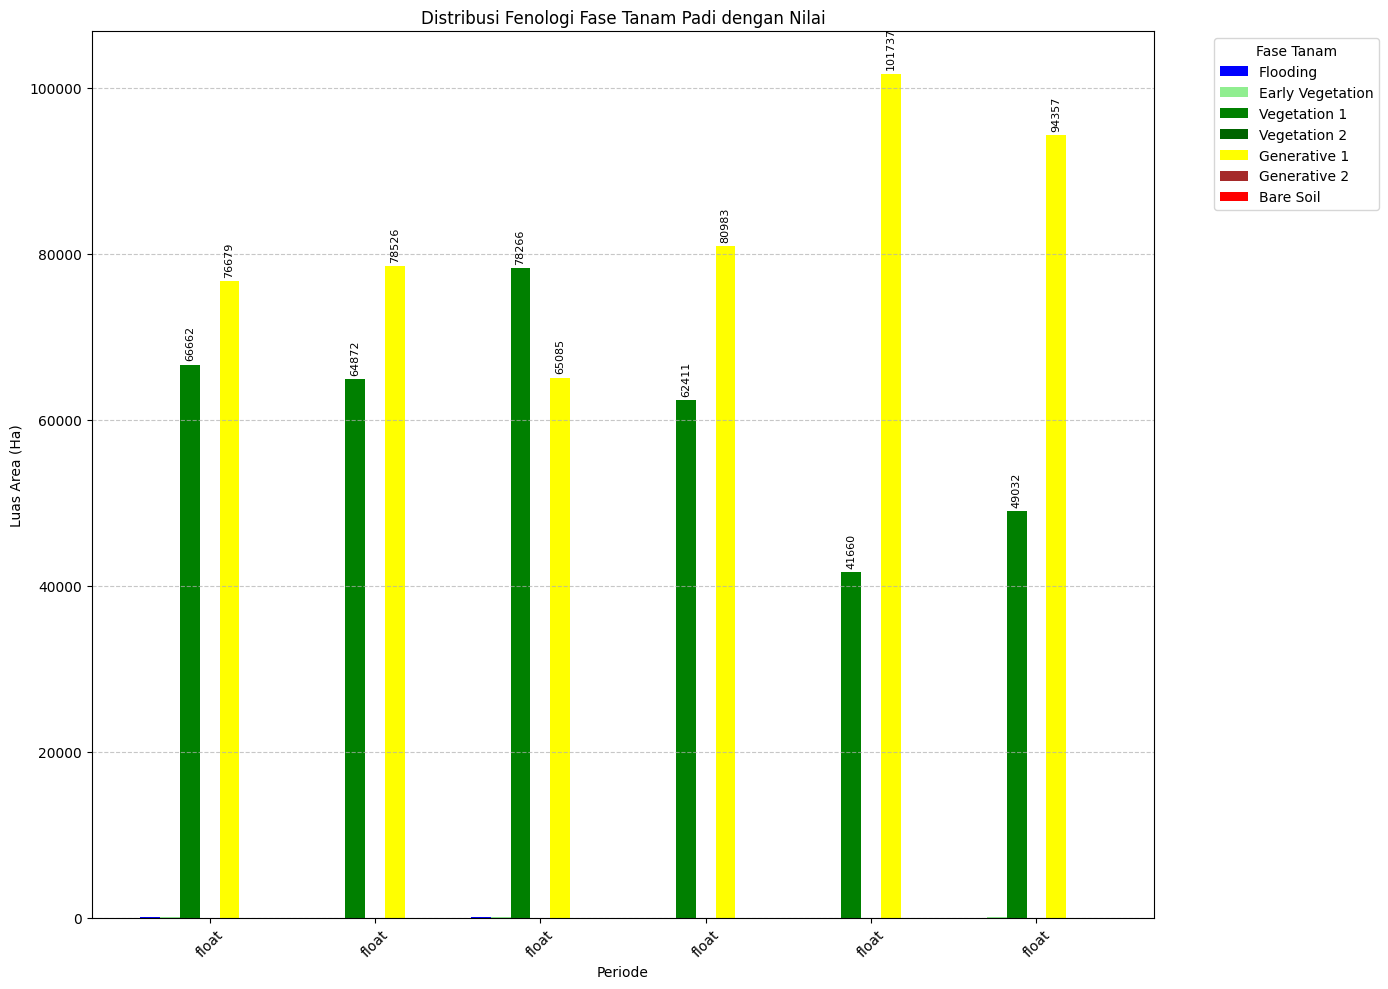

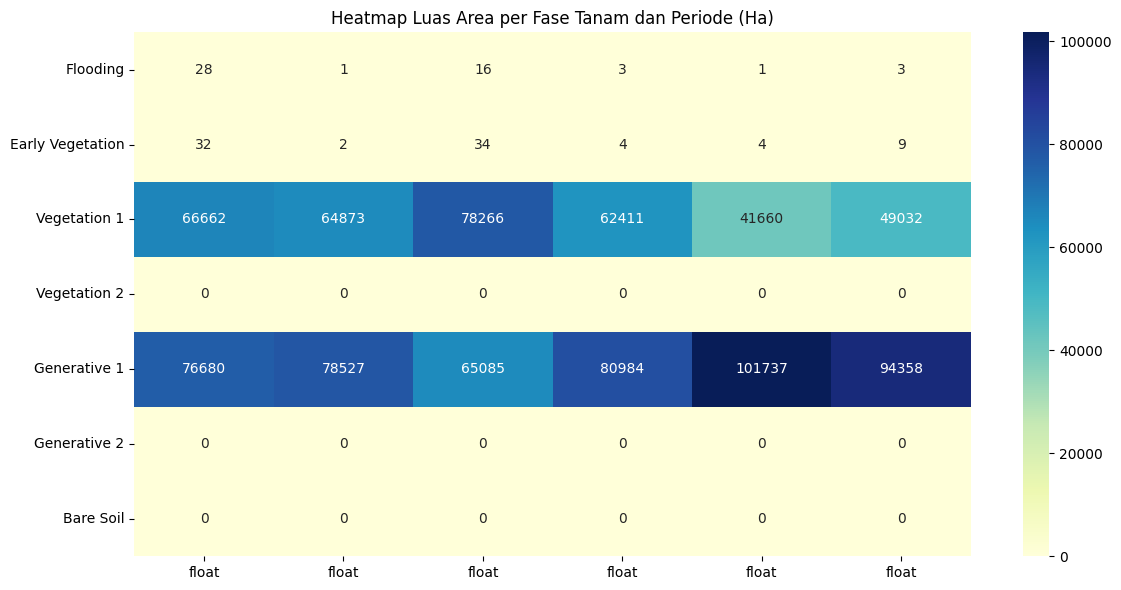

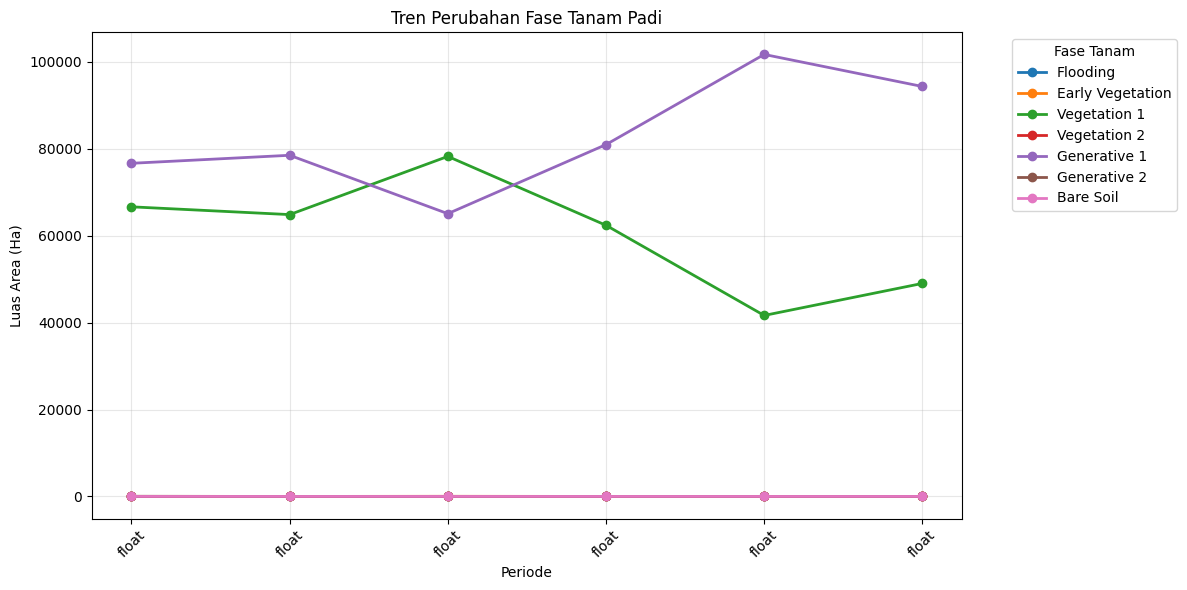

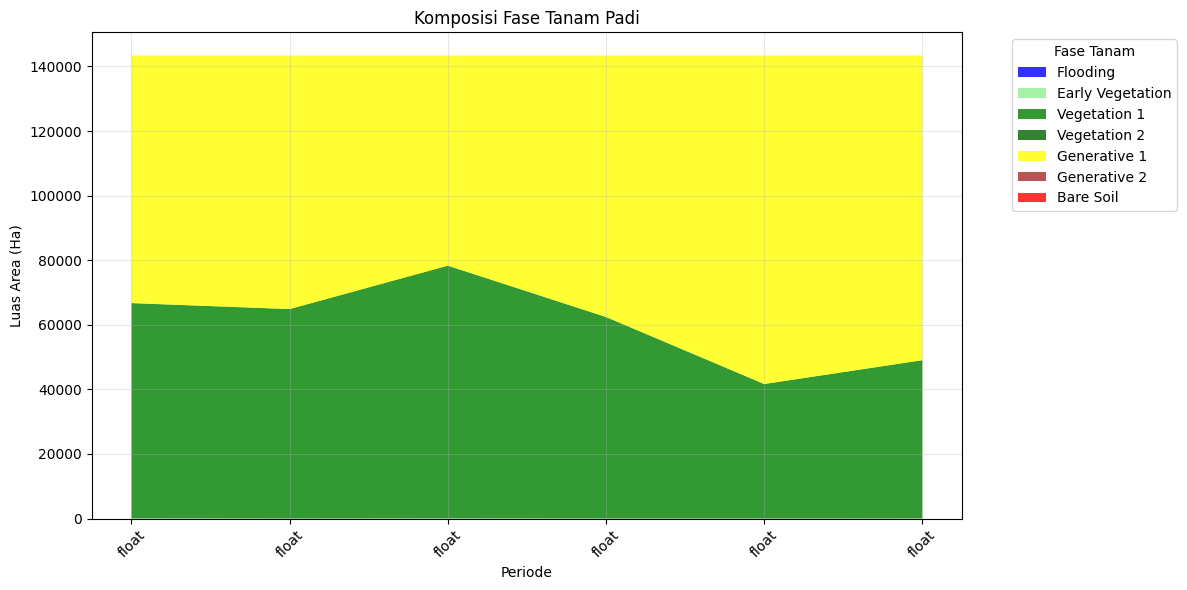

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Direktori path Google Drive yang telah ditentukan
google_drive_path = '/content/drive/MyDrive/Research Sentinel-1 Dataset_S1-ARD_Indramayu_2024'
os.makedirs(google_drive_path, exist_ok=True)

print(f"Direktori penyimpanan: {google_drive_path}")
print(f"Direktori ada dan siap digunakan: {os.path.exists(google_drive_path)}")

# Tentukan label, kelas, dan ukuran piksel dalam hektar
labels = ['Flooding', 'Early Vegetation', 'Vegetation 1', 'Vegetation 2', 'Generative 1', 'Generative 2', 'Bare Soil']
classes = [0, 1, 2, 3, 4, 5, 6]
pixel_area_ha = 0.01  # 10x10 m Sentinel-2

# Fungsi untuk menghitung luas kelas
def calculate_class_areas(classified_map, classes, pixel_area_ha):
    areas = {cls: np.sum(classified_map == cls) * pixel_area_ha for cls in classes}
    return areas

# Buat dictionary untuk menyimpan hasil perhitungan area
area_results = {}

# Loop melalui setiap periode dalam classified_data
for key, classified in classified_data.items():
    # Hitung area untuk periode tersebut
    areas = calculate_class_areas(classified, classes, pixel_area_ha)
    area_results[key] = areas

# Buat DataFrame untuk analisis
area_df = pd.DataFrame({
    "Fase Tanam": labels,
    **{key: [area_results[key][cls] for cls in classes] for key in area_results}
})

# Tampilkan tabel nilai
print("Distribusi Luas Area per Fase Tanam (Ha):")
print(area_df)

# Hitung total area per fase tanam
area_df['Total per Fase'] = area_df.iloc[:, 1:].sum(axis=1)
print("\nTotal Luas Area per Fase Tanam (Ha):")
print(area_df[['Fase Tanam', 'Total per Fase']])

# Hitung total area per periode
total_per_periode = area_df.iloc[:, 1:-1].sum(axis=0)
total_df = pd.DataFrame(total_per_periode, columns=['Total Area (Ha)'])
total_df.index.name = 'Periode'
print("\nTotal Luas Area per Periode (Ha):")
print(total_df)

# Buat subfolder untuk hasil analisis
results_folder = os.path.join(google_drive_path, 'analisis_fenologi')
os.makedirs(results_folder, exist_ok=True)

# Simpan data ke CSV di Google Drive
area_csv_path = os.path.join(results_folder, 'distribusi_fenologi_area SVM.csv')
area_df.to_csv(area_csv_path, index=False)

total_csv_path = os.path.join(results_folder, 'total_area_per_periode SVM.csv')
total_df.to_csv(total_csv_path)

print(f"\nData berhasil disimpan ke Google Drive di folder: {results_folder}")
print(f"- File area per fase: {os.path.basename(area_csv_path)}")
print(f"- File total per periode: {os.path.basename(total_csv_path)}")

# Buat subfolder untuk visualisasi
vis_folder = os.path.join(google_drive_path, 'visualisasi_fenologi')
os.makedirs(vis_folder, exist_ok=True)

# Warna untuk setiap kelas fenologi
colors = ['blue', 'lightgreen', 'green', 'darkgreen', 'yellow', 'brown', 'red']

# Visualisasi data dengan nilai di atas bar
plt.figure(figsize=(14, 10))

# Indeks untuk sumbu X
x = np.arange(len(area_results.keys()))
bar_width = 0.12  # Lebar batang

# Plot bars untuk setiap kelas fenologi dengan nilai di atasnya
for i, cls in enumerate(classes):
    values = [area_results[key][cls] for key in area_results.keys()]
    bars = plt.bar(x + i * bar_width, values, width=bar_width, label=labels[i], color=colors[i])

    # Tambahkan nilai di atas bar
    for bar in bars:
        height = bar.get_height()
        if height > 1000:  # Hanya tampilkan nilai yang cukup signifikan
            plt.text(bar.get_x() + bar.get_width()/2., height + 500,
                    f'{int(height)}', ha='center', va='bottom', rotation=90, fontsize=8)

# Add labels, title, and grid
plt.xticks(x + (len(classes) - 1) * bar_width / 2, [k.split('_')[-1] for k in area_results.keys()], rotation=45)
plt.xlabel('Periode')
plt.ylabel('Luas Area (Ha)')
plt.title('Distribusi Fenologi Fase Tanam Padi dengan Nilai')
plt.legend(title='Fase Tanam', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# # Simpan plot ke Google Drive
# plot_path = os.path.join(vis_folder, 'distribusi_fenologi_dengan_nilai.png')
# plt.savefig(plot_path, dpi=300, bbox_inches='tight')
# plt.show()

# Membuat heatmap untuk visualisasi nilai yang lebih jelas
plt.figure(figsize=(12, 6))
sns.heatmap(area_df.iloc[:, 1:-1], annot=True, fmt='.0f', cmap='YlGnBu',
            xticklabels=[k.split('_')[-1] for k in area_results.keys()],
            yticklabels=labels)
plt.title('Heatmap Luas Area per Fase Tanam dan Periode (Ha)')
plt.tight_layout()

# # Simpan heatmap ke Google Drive
# heatmap_path = os.path.join(vis_folder, 'heatmap_fenologi.png')
# plt.savefig(heatmap_path, dpi=300, bbox_inches='tight')
# plt.show()

# Tambahkan visualisasi perubahan fase per periode
plt.figure(figsize=(12, 6))
for i, cls in enumerate(classes):
    values = [area_results[key][cls] for key in area_results.keys()]
    plt.plot(range(len(values)), values, marker='o', linewidth=2, label=labels[i])

plt.xticks(range(len(area_results.keys())), [k.split('_')[-1] for k in area_results.keys()], rotation=45)
plt.xlabel('Periode')
plt.ylabel('Luas Area (Ha)')
plt.title('Tren Perubahan Fase Tanam Padi')
plt.legend(title='Fase Tanam', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()

# # Simpan tren plot ke Google Drive
# trend_path = os.path.join(vis_folder, 'tren_fenologi.png')
# plt.savefig(trend_path, dpi=300, bbox_inches='tight')
# plt.show()

# Bonus: Stacked Area Chart untuk menampilkan komposisi fase tanam per periode
plt.figure(figsize=(12, 6))
data_stack = np.array([[area_results[key][cls] for key in area_results.keys()] for cls in classes])
plt.stackplot(range(len(area_results.keys())), data_stack, labels=labels, colors=colors, alpha=0.8)

plt.xticks(range(len(area_results.keys())), [k.split('_')[-1] for k in area_results.keys()], rotation=45)
plt.xlabel('Periode')
plt.ylabel('Luas Area (Ha)')
plt.title('Komposisi Fase Tanam Padi')
plt.legend(title='Fase Tanam', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()

# # Simpan stacked area chart ke Google Drive
# stacked_path = os.path.join(vis_folder, 'komposisi_fenologi.png')
# plt.savefig(stacked_path, dpi=300, bbox_inches='tight')
# plt.show()

# Buat file info.txt yang berisi informasi tentang analisis
info_text = f"""
Analisis Distribusi Fenologi Fase Tanam Padi
=============================================
Tanggal analisis: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}

Informasi Dataset:
- Jumlah fase tanam: {len(labels)}
- Jumlah periode: {len(area_results.keys())}
- Ukuran piksel: {pixel_area_ha} hektar

Total luas area per fase tanam:
{area_df[['Fase Tanam', 'Total per Fase']].to_string(index=False)}

Total luas area per periode:
{total_df.to_string()}

File yang dihasilkan:
1. CSV data distribusi: distribusi_fenologi_area.csv
2. CSV total per periode: total_area_per_periode.csv
3. Visualisasi:
   - distribusi_fenologi_dengan_nilai.png
   - heatmap_fenologi.png
   - tren_fenologi.png
   - komposisi_fenologi.png
"""

# # Simpan file info
# info_path = os.path.join(google_drive_path, 'info_analisis_fenologi.txt')
# with open(info_path, 'w') as f:
#     f.write(info_text)

print(f"\nSemua visualisasi berhasil disimpan ke Google Drive di folder: {vis_folder}")
print(f"File informasi tersimpan di: {info_path}")